# 1. Env Setup

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import string
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2

In [2]:
import kagglehub

# 下载最新版本数据集（注意：下载目录结构可能为：path/images/*.png）
path = kagglehub.dataset_download("parsasam/captcha-dataset")
print("Path to dataset files:", path)

C:\Users\tfgmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\tfgmo\.cache\kagglehub\datasets\parsasam\captcha-dataset\versions\1


# 2. Data Preprocessing

In [3]:
# 参数设置
img_width = 200
img_height = 64  # 建议图像高度设置为64，这样经过多次pooling后尺寸更合理
batch_size = 1024
max_label_len = 5   # 假设每个验证码均为5个字符

epochs = 20

In [4]:
# 定义字符集（数字 + 大写字母 + 小写字母，共62个字符）
characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
# 在这里我们让字符映射从0开始，最后一个索引预留给 blank
char_to_num = {char: i for i, char in enumerate(characters)}
num_to_char = {i: char for char, i in char_to_num.items()}
# blank index 设为 len(characters)
blank_idx = len(characters)
num_classes = len(characters) + 1  # 加上 blank

def text_to_labels(text):
    """将验证码文本转换为数字列表（不含 blank）"""
    return [char_to_num[c] for c in text]

In [ ]:
# def captcha_preprocessing(pil_img):
#     """
#     对验证码图像进行去噪、二值化和形态学处理，
#     并将结果转换为3通道图像
#     """
#     # 将 PIL Image 转为 numpy array (H, W, 3)，RGB 顺序
#     np_img = np.array(pil_img)
    
#     # 转为 BGR 以便使用 OpenCV 接口
#     np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    
#     # 转为灰度（注意：这一步不能注释掉）
#     gray = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
    
#     # 自适应阈值：现在传入的 gray 就是单通道图像
#     binary = cv2.adaptiveThreshold(
#         gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#         cv2.THRESH_BINARY, blockSize=11, C=2
#     )
    
#     # 形态学操作：开运算去噪
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
#     opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    
#     # 将单通道图转换回3通道图（灰度图扩展为3通道）
#     opened_color = cv2.cvtColor(opened, cv2.COLOR_GRAY2BGR)
    
#     # 转回 PIL Image（RGB格式）
#     processed_pil = Image.fromarray(cv2.cvtColor(opened_color, cv2.COLOR_BGR2RGB))
#     return processed_pil

In [ ]:
class CaptchaDataset(data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        # 加载图像，转为RGB
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_width, img_height))
        if self.transform:
            img = self.transform(img)
        else:
            # 默认转换成 tensor，并归一化 [0,1]
            img = transforms.ToTensor()(img)
        # img 的 shape 为 (3, H, W)
        
        # 从文件名中提取标签（假设格式为 ..._{label}.png）
        basename = os.path.basename(img_path)
        label_str = os.path.splitext(basename)[0].split('_')[-1]
        label = text_to_labels(label_str)
        label_len = len(label)
        return img, torch.tensor(label, dtype=torch.long), label_len, label_str

def collate_fn(batch):
    """
    batch中每个元素为 (img, label_tensor, label_length, label_str)
    由于所有图片尺寸已固定，可以直接 stack
    对于 CTCLoss，目标序列需拼接成一维张量
    """
    imgs, labels, label_lens, label_strs = zip(*batch)
    imgs = torch.stack(imgs, 0)  # (batch, 3, H, W)
    # 拼接所有标签
    targets = torch.cat([lbl for lbl in labels])
    target_lengths = torch.tensor(label_lens, dtype=torch.long)
    # 对于输入序列长度，我们在模型中固定输出时间步数为 T
    # 根据网络结构，经过3次卷积和pooling后宽度200 -> 200/2 -> 100/2 -> 50 (最后pooling为 (2,1))
    # 因此我们设 T = 50
    input_lengths = torch.full(size=(len(batch),), fill_value=50, dtype=torch.long)
    return imgs, targets, input_lengths, target_lengths, label_strs

In [ ]:
dataset_dir = os.path.join(path, "images")
if not os.path.exists(dataset_dir):
    dataset_dir = path

all_images = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
np.random.shuffle(all_images)
split_index = int(len(all_images) * 0.9)
train_images = all_images[:split_index]
val_images = all_images[split_index:]

# 定义 transform：转换成 tensor即可（归一化已在 ToTensor 内部完成）
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CaptchaDataset(train_images, transform=transform)
val_dataset = CaptchaDataset(val_images, transform=transform)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# 3. Modeling

In [8]:
class CRNN(nn.Module):
    def __init__(self, num_classes, num_chars=5):
        super(CRNN, self).__init__()
        # 保留原有的 CNN 特征提取部分
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,1), (2,1))
        )
        # 改为全局特征提取
        self.fc = nn.Linear(128 * 8 * 50, 512)  # 根据 conv 输出尺寸调整
        self.dropout = nn.Dropout(0.25)
        # 输出固定 5 个字符，每个字符分类（num_classes，不含 blank）
        self.classifiers = nn.ModuleList([
            nn.Linear(512, num_classes) for _ in range(num_chars)
        ])
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        batch_size = x.size(0)
        # flatten 所有空间维度
        x = x.view(batch_size, -1)
        x = self.dropout(x)
        x = self.fc(x)
        # 对每个字符位置预测
        outputs = [classifier(x) for classifier in self.classifiers]
        # outputs: list of [batch_size, num_classes] -> 合并为 [batch_size, num_chars, num_classes]
        outputs = torch.stack(outputs, dim=1)
        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_classes).to(device)
print(model)


# ------------------------------
# 使用预训练模型
# ------------------------------
# 假设预训练权重文件路径如下（你需要先下载或者生成这个文件）
pretrained_model_path = 'crnn.pth'

if os.path.exists(pretrained_model_path):
    # 首先将权重加载到 CPU
    pretrained_dict = torch.load(pretrained_model_path, map_location='cpu')
    model_dict = model.state_dict()
    
    # 过滤掉不匹配的层（比如最后分类层维度不同）
    pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                       if k in model_dict and v.size() == model_dict[k].size()}
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    # 加载权重后再将模型移动到目标设备（例如 cuda）
    model.to(device)
    
    print("Loaded pretrained weights successfully.")
else:
    print("Pretrained model not found, training from scratch.")

# 如果预训练模型的分类器层（self.classifier）输出维度与当前任务不匹配，
# 你可以重新定义该层（例如）：
in_features = model.classifier.in_features  # 输入维度
model.classifier = nn.Linear(in_features, num_classes).to(device)
print("Adjusted classifier layer for our character set.")

ctc_loss = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# early stopping 参数
patience = 5
best_val_loss = np.inf
epochs_no_improve = 0
best_model_wts = deepcopy(model.state_dict())

# 用于记录训练和验证 loss
train_losses = []
val_losses = []

device

CRNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1024, out_features=64, bias=True)
  (gru): GRU(64, 128, batch_first=True, dropout=0.25, bidirectional=True)
  (classifier): Linear(in_features=256, out_features=63, bias=True)
  (log_softmax): LogSoftmax(dim=2)
)
Loaded pretrained weights successfully.
Adjusted classifier layer for our character set.


C:\Users\tfgmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


device(type='cuda')

## Model Training

In [9]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    scaler = torch.GradScaler("cuda")

    for imgs, targets, input_lengths, target_lengths, _ in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)
        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)
        
        optimizer.zero_grad()
        
        with torch.autocast("cuda"):
            outputs = model(imgs)
            loss = ctc_loss(outputs, targets, input_lengths, target_lengths)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # 验证
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for imgs, targets, input_lengths, target_lengths, _ in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            input_lengths = input_lengths.to(device)
            target_lengths = target_lengths.to(device)
            
            outputs = model(imgs)
            loss = ctc_loss(outputs, targets, input_lengths, target_lengths)
            val_running_loss += loss.item() * imgs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} Train Loss: {epoch_loss:.4f} Val Loss: {val_loss:.4f}")
    
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
        print("=> Validation loss decreased, saving model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("=> Early stopping")
            break

# 加载最佳模型权重
model.load_state_dict(best_model_wts)

Epoch 1/20 Train Loss: 6.8858 Val Loss: 4.4338
=> Validation loss decreased, saving model.
Epoch 2/20 Train Loss: 4.4337 Val Loss: 4.4340
Epoch 3/20 Train Loss: 4.4338 Val Loss: 4.4350
Epoch 4/20 Train Loss: 4.4341 Val Loss: 4.4348
Epoch 5/20 Train Loss: 4.4345 Val Loss: 4.4354
Epoch 6/20 Train Loss: 4.4343 Val Loss: 4.4347
=> Early stopping


<All keys matched successfully>

## 4. Model Validation

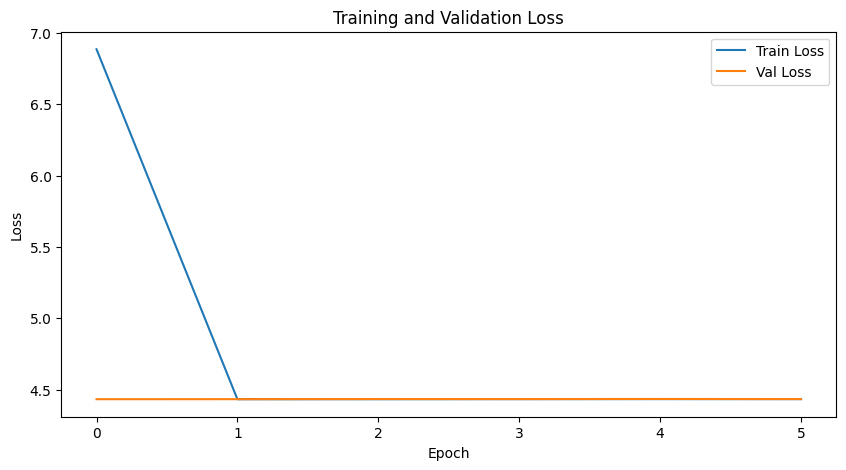

Captcha Accuracy: 0.00%
Character Accuracy: 0.00%


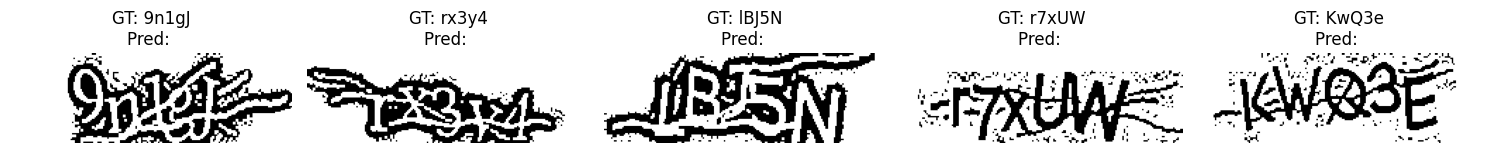

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ------------------------------
# 8. 定义预测函数（贪婪解码）
# ------------------------------
def greedy_decode(output, blank=blank_idx):
    # output shape: (T, B, C) -> 转为 (B, T, C)
    output = output.permute(1, 0, 2)
    # 对每个时间步取最大值的索引
    pred_indices = torch.argmax(output, dim=2).cpu().numpy()  # (B, T)
    decoded_preds = []
    for indices in pred_indices:
        # 去除重复和 blank
        prev = -1
        pred = []
        for idx in indices:
            if idx != prev and idx != blank:
                pred.append(idx)
            prev = idx
        # 将数字转换为字符
        pred_text = ''.join([num_to_char[i] for i in pred])
        decoded_preds.append(pred_text)
    return decoded_preds

# ------------------------------
# 9. 在验证集上评估模型性能
# ------------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, targets, input_lengths, target_lengths, label_strs in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = greedy_decode(outputs, blank=blank_idx)
        all_preds.extend(preds)
        all_labels.extend(label_strs)

# 计算验证码准确率和字符级准确率
correct_captcha = 0
total_chars = 0
correct_chars = 0
for gt, pred in zip(all_labels, all_preds):
    if gt == pred:
        correct_captcha += 1
    min_len = min(len(gt), len(pred))
    correct = sum(1 for i in range(min_len) if gt[i] == pred[i])
    correct_chars += correct
    total_chars += len(gt)

captcha_accuracy = correct_captcha / len(all_labels)
character_accuracy = correct_chars / total_chars if total_chars > 0 else 0

print("Captcha Accuracy: {:.2%}".format(captcha_accuracy))
print("Character Accuracy: {:.2%}".format(character_accuracy))

# ------------------------------
# 10. 可视化部分验证样本的预测结果
# ------------------------------
# 从最后一个 batch 中随机选择几个样本
imgs, targets, input_lengths, target_lengths, label_strs = next(iter(val_loader))
imgs = imgs.to(device)
with torch.no_grad():
    outputs = model(imgs)
preds = greedy_decode(outputs, blank=blank_idx)

# 转回 CPU 用于显示
imgs = imgs.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, C)
num_samples = 5
plt.figure(figsize=(15,3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(imgs[i])
    plt.title(f"GT: {label_strs[i]}\nPred: {preds[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()